In [15]:
import pandas as pd
import numpy as np
import dask.array as da
import dask.dataframe as df
import h5py as h5

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.externals import joblib

from tqdm import tqdm

In [109]:
# Start client
# client = Client('10.70.1.160:8786')
# client = Client(processes=False)

In [2]:
# Parameters
DATA_PATH = r'../data/eightieth.h5' # Path to the learning dataset
CHUNK_SIZE = 5000 # Number of images to process in one batch (must fit comfortably in memory)
TRAIN_SIZE = 7/8 # Size of the train dataset (compared to the total dataset)


# data_h5 = h5.File('data/eightieth.h5', mode='r')
# landcover = da.from_array(data_h5['TOP_LANDCOVER'], chunks=(1000,1))
# images = da.from_array(data_h5['S2'], chunks=(1000,16,16,4))

In [3]:
# Setup generator yielding X, y chunks (default size 1000)

classes = da.unique(da.from_array(h5.File(DATA_PATH)['TOP_LANDCOVER'], chunks=(CHUNK_SIZE,1))).compute()

def generator(h5_path, chunk_size, train_size):
    f = h5.File(h5_path, 'r')
    X = f['S2']
    y = f['TOP_LANDCOVER']
    
    # Compute number of chunks needed
    no_chunks = len(X) // chunk_size
    if len(X) % chunk_size > 0:
        # len(X) is not an exact multiple of chunk_size
        no_chunks += 1
    
    print(len(X), '-', no_chunks)
    for c in range(no_chunks):
        X_to_yield = X[c*chunk_size:(c+1)*chunk_size,:,:,:]
        y_to_yield = y[c*chunk_size:(c+1)*chunk_size,:]
        
        # Wrangle data
        X_to_yield = np.array(X_to_yield).reshape((-1, 16*16*4)) # Flatten each element in the array
        y_to_yield = np.array(y_to_yield).astype(int).reshape((-1,))
        y_to_yield = label_binarize(y_to_yield, classes=classes)
        
        
        yield train_test_split(X_to_yield, y_to_yield, train_size=train_size, test_size=1-train_size)
    
# Test
# for X, y in generator('data/eightieth.h5', 1000):
#     pass

In [4]:
forests_list = [] # List of forests to aggregate

for X_train, X_test, y_train, y_test in tqdm(generator(DATA_PATH, CHUNK_SIZE, TRAIN_SIZE)):
    cf = RandomForestClassifier(n_estimators=10, n_jobs=-1) # parameters to define
    cf.fit(X=X_train, y=y_train)
    
#     Reshape y_test to make it understandable (1D series)
    score = cf.score(X_test, y_test)
    
    forests_list.append((cf, score))
    
forests_list = np.array(forests_list)
print('Mean score:', forests_list[:,1].mean())

0it [00:00, ?it/s]

234000 - 47


47it [01:18,  1.67s/it]


Mean score: 0.4583319148936169


In [5]:
# Custom VotingClassifier
# Can ensemble pre-fitted models (as opposed to sklearn's implementation which needs retraining)

class VotingClassifier:
    # Two voting modes :
        # - Hard: the majority wins, if there's a tie, a contender is selected randomly
        # - Soft: use the provided weights and tally the weighted votes to determine winners. Weights must have shape (len(estimators))
    
    def __init__(self, estimators, classes=None, weights=None):
        # estimators: iterable of estimators implementing the predict() API
        # weights: iterable of (numeric) weights
        # classes: list of matching classes
        
        self.estimators = estimators
        self.weights = np.array(weights)
        self.n_classes = len(self.estimators[0].n_classes_)
        
    
    def _special_argmax(self, pred):
        # Compute the usual argmax along the lines
        # For each null predictions ([0]*no_features), replace the argmax with -1 to filter it easily
        # Having an argmax of 0 then actually means that the predicted label is the #0

        # pred shape=(no_classifiers, no_features)
        out = pred.argmax(axis=1)
        out[np.all(pred==-1.0, axis=1)] = self.n_classes + 1

        return out

    def predict(self, X):
        # X is of shape (no_samples, no_features)
        # Return array of shape (no_samples,)

        predictions = np.empty((len(self.estimators), X.shape[0], self.n_classes))
        
        for i, clf in enumerate(self.estimators):
            predictions[i, :, :] = clf.predict(X)
            
        # predictions is of shape (no_classifiers, no_samples, no_features)
        
        out = np.zeros((X.shape[0],)) # out matrix
        
        for k in range(predictions.shape[1]):
            arr = predictions[:, k, :]
            
            # Replace all the 0 to -1 (in order to filter out the null prediction later on)
            np.place(arr, arr==0.0, -1)
            
            arr_label = self._special_argmax(arr)
            
            idx_label = ~(arr_label == self.n_classes + 1)
            
            out[k] = np.argmax(np.bincount(arr_label[idx_label], 
                                           weights=weights[idx_label]))
            
        return out    
    
    def score(self, X, y):
        # Convert y to its category label
        y = y.argmax(axis=1)
        y_pred = self.predict(X)
        
        accuracy = accuracy_score(y, y_pred)
        fbeta = fbeta_score(y, y_pred, 2, average='macro')
        
        print('Accuracy :', accuracy)
        print('F2 score :', fbeta)

In [6]:
weights = forests_list[:,1].astype(float)
vc = VotingClassifier(forests_list[:,0], weights=weights)
# predictions = vc.predict(X_test)
vc.score(X_test, y_test)

C:\Program Files\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy : 0.364
F2 score : 0.19014772914352537


In [6]:
# Write the model to the disk
joblib.dump(vc, 'vc.pkl')

['vc.pkl']

In [32]:
arr = da.from_array(h5.File(DATA_PATH)['S2'], chunks=(CHUNK_SIZE,16, 16, 4))
label = da.from_array(h5.File(DATA_PATH)['TOP_LANDCOVER'], chunks=(CHUNK_SIZE,1))

In [43]:
(label == 1.0).reshape(-1,).shape

(234000,)

In [45]:
label_1 = arr[(label == 1.0).reshape(-1,)].compute()

In [50]:
label_1.shape

(10988, 16, 16, 4)

<IPython.core.display.Javascript object>


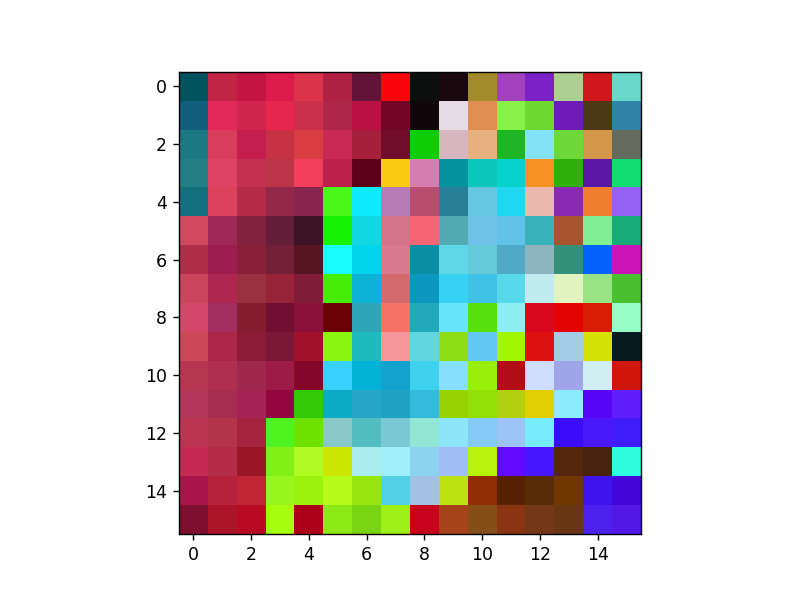

In [61]:
%matplotlib notebook
from matplotlib import pyplot
img = label_1[250,:,:,0:3]

pyplot.imshow(img)

In [25]:
arr[(label == 1.0).to_array()].compute()

AttributeError: 'DataFrame' object has no attribute 'to_array'